In [1]:
#!pip install proglearn
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
!unzip /content/ISIC2018_Task1-2_Training_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
!unzip /content/ISIC2018_Task1_Training_GroundTruth.zip

Streaming output truncated to the last 5000 lines.
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000225.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000226.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000227.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000228.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000229.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000230.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000231.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000232.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000233.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000234.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000235.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000236.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000239.jpg  
 extracting: ISIC2018_Task1-2_Training_Input/ISIC_0000240.jpg  
 extracting: ISIC2018_Task1-2_Training_Input/ISIC_000

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import KFold

In [2]:
seed = 1
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_path_correct = ''
        self.mask_path_correct = ''
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "ISIC2018_Task1-2_Training_Input", id_name) + ".jpg"
        mask_path = os.path.join(self.path, "ISIC2018_Task1_Training_GroundTruth", id_name) + "_segmentation.png"
        
        ## Reading Image
        try:
            image = cv2.imread(image_path,1)
            image = cv2.resize(image, (self.image_size, self.image_size))
            mask = np.zeros((self.image_size, self.image_size, 1))
            _mask = cv2.imread(mask_path, -1)
            _mask = cv2.resize(_mask, (self.image_size, self.image_size))
            _mask = np.expand_dims(_mask, axis=-1)
            mask = np.maximum(mask, _mask)
            
            
            ## Normalizaing 
            image = image/255.0
            mask = mask/255.0
            self.img_path_correct = image_path
            self.mask_path_correct = mask_path
            return image, mask
        except:
            if self.img_path_correct != '':
                image = cv2.imread(self.img_path_correct,1)
                
                image = cv2.resize(image, (self.image_size, self.image_size))
                image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
                mask = np.zeros((self.image_size, self.image_size, 1))
                
                _mask = cv2.imread(self.mask_path_correct, -1)
                _mask = cv2.resize(_mask, (self.image_size, self.image_size))
                _mask = np.expand_dims(_mask, axis=-1)
                mask = np.maximum(mask, _mask)
                mask = cv2.rotate(mask, cv2.cv2.ROTATE_90_CLOCKWISE)
                
                
                ## Normalizaing 
                image = image/255.0
                mask = mask/255.0
                return image, mask
            else:
                image = np.ones((self.image_size, self.image_size))
                mask = np.ones((self.image_size, self.image_size))
                ## Normalizaing 
                image = image/255.0
                mask = mask/255.0
                
                return image, mask

    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = tf.convert_to_tensor(image)
        mask  = tf.convert_to_tensor(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [4]:
image_size = 128
path = "./"
train_path = "./ISIC2018_Task1-2_Training_Input"
epochs = 1
batch_size = 19
num_tasks = 5
train_batches = 10
val_batches = 1

## Training Ids
train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]
data_ids = [i.split('.', 1)[0] for i in train_ids]

In [4]:
training_data = DataGen(train_ids, path, batch_size=batch_size, image_size=image_size)
x, y = training_data[0]
print(x.shape, y.shape)

(19, 128, 128) (19, 128, 128)


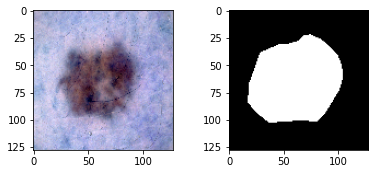

In [7]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [5]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [6]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [10]:
def dice(seg, gt):
    intersection = tf.reduce_sum(tf.cast(tf.equal(seg, gt), tf.float32))
    return intersection * 2.0 / tf.cast(tf.size(seg) + tf.size(gt), tf.float32)


In [8]:
results = {
    "train_loss" : np.empty((num_tasks, epochs)),
    "train_acc" : np.empty((num_tasks, epochs)),
    "val_loss" : np.empty((num_tasks, epochs)),
    "val_acc" : np.empty((num_tasks, epochs)),
}
data_ids = random.shuffle(data_ids)
for task in range(0, num_tasks):
    train_ids = data_ids[task * batch_size * (train_batches + val_batches):(task+1) * batch_size * (train_batches + val_batches)]
    train_gen = DataGen(train_ids[:-val_batches*batch_size], path, batch_size)
    valid_gen = DataGen(train_ids[train_batches*batch_size:], path, batch_size)

    model = UNet()
    #lcn = LifelongClassificationNetwork(model, loss='binary_crossentropy', epochs=epochs, batch_size=batch_size)
    #lcn
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

    train_steps = len(train_ids[:-val_batches*batch_size])//batch_size
    valid_steps = len(train_ids[train_batches*batch_size:])//batch_size

    history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs = epochs)
    results['train_loss'][task, :] = history.history['loss']
    results['train_acc'][task, :] = history.history['acc']
    results['val_loss'][task, :] = history.history['val_loss']
    results['val_acc'][task, :] = history.history['val_acc']

10/10 [==============================] - 120s 12s/step - loss: 0.6279 - acc: 0.7736 - val_loss: 0.5041 - val_acc: 0.7883


In [9]:
print("Mean Task Train Accuracy: {}".format(np.mean(results['train_acc'][:, -1])))
print("Standard Deviation Task Train Accuracy: {}".format(np.std(results['train_acc'][:, -1])))
print("Mean Task Validation Accuracy: {}".format(np.mean(results['val_acc'][:, -1])))
print("Standard Deviation Task Validation Accuracy: {}".format(np.std(results['val_acc'][:, -1])))

Mean Task Train Accuracy: 0.7529878377914428
Standard Deviation Task Train Accuracy: 0.034798235034862686
Mean Task Validation Accuracy: 0.8149806022644043
Standard Deviation Task Validation Accuracy: 0.02087152574570378


In [ ]:
epochs = history.epoch
plt.figure(figsize=(22,5))

plt.subplot(1,3,1)
plt.plot(epochs, results['train_loss'], label="Training Loss")
plt.plot(epochs, results['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Loss vs. Epoch")
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, results['train_accuracy'], label="Training Accuracy")
plt.plot(epochs, results['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.subplot(1,3,3)
plt.plot(epochs, results['train_dice'], label="Training Dice")
plt.plot(epochs, results['val_dice'], label="Validation Dice")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Dice Coefficient vs. Epoch")